# MNIST DATA SET PREDICTION USING A SIMPLE MLP

## Author: Moreen Owino 

Here i used my knowledge of neural networks to create a simple one layer MLP that is trained on the MNIST data set and is then used to predict the test image samples.It is coded from scratch using numpy.
   

##  load the necessary libraries
start by loading the necessary libraries

In [47]:
import numpy as np # for doing calculations etc
import pandas as pd # for importing data sets
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt #for plotting digits

## load MNIST data sets
The training and testing data sets are then loaded in below and the pandas data frames converted to numpy arrays to allow for numpy operations on the data sets.

In [48]:
xtrain = pd.read_csv('mnist_train.csv')
x_test = pd.read_csv('mnist_test.csv')
y_targets = pd.read_csv('mnist_train_targets.csv')
xtrain = xtrain.to_numpy()
x_test = x_test.to_numpy() # converting to numpy arrays
y_targets = y_targets.to_numpy()


## Data preprocessing


### normalizing the data

The training data and test data contain images that are typically flattened into  one-dimensional arrays of length 784 (28x28=784)pixels.To normalize the pixel values to a range between 0 and 1, it is common to divide each element in the Xtrain and x_test array  by 255, which is the maximum possible pixel value.so we go ahead and divide the arrays by 255 in order to normalize the values

In [49]:
xtrain = xtrain/255
x_test = x_test/255

### one-hot encoding the target matrix
We then one-hot encode the MNIST train targets to prepare them for the classification task. The target values are integers between 0 and 9, representing the actual digit in the corresponding image. If we use these integers as they are, the machine learning model might interpret them as continuous variables, which could lead to incorrect predictions. One-hot encoding converts each integer target value into a binary vector of length equal to the number of classes (i.e., 10 for MNIST). Each element of the vector is either 0 or 1, and corresponds to a specific class. The element corresponding to the actual class is set to 1, while all other elements are set to 0.The one hot conversion is done in the code chunk below.

In [50]:
values=10 # number of unique values or digits
numbers=y_targets.shape[0] # getting the number of rows in the targets matrix

y=y_targets.reshape(1, numbers)
y_new=np.eye(values)[y.astype('int32')] #  uses advanced indexing to create a new array of shape (y.shape[0], values) where, 
# each row is a one-hot encoded representation of the corresponding element in y.

targets=y_new.T.reshape(values, numbers)# Transforming the matrix so that we have the one one hot encoded digit per column.
np.shape(targets)


(10, 60000)

### Shuffling the training data
This shuffling operation is often used in machine learning to randomize the order of training samples in order to prevent the model from learning patterns that may be specific to the order of the samples. By shuffling the data, the model is forced to learn general patterns that apply to all training samples, which can lead to better generalization performance on new, unseen data.
In the code below random.permutation is used to generate the shuffled indexes that are then used to form the new arrays.

In [58]:
# Shuffle the data
np.random.seed(138)
k=60000 # number of columns of image samples
shuffle_index=np.random.permutation(k) #shuffles the integers from 0 to k-1 randomly 
xtrain, targets = xtrain[:, shuffle_index], targets[:, shuffle_index] # new arrays with shuffled indexes

### plotting the data 
Let us plot a number just to have an idea of what kind of data we are trying to predict and to ensure that our data is all intact.we look at a random image i. i use the cmap=plt.cm.binary parameter to display the images in black and white, and use the axis('off') method to remove the axes labels.finaly plt.show is used to display the figure.

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


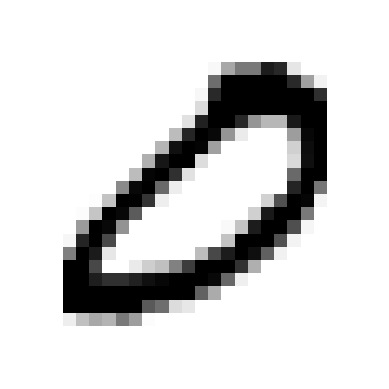

In [59]:
i=3
plt.imshow(xtrain[:,i].reshape(28,28), cmap = plt.cm.binary) # displays the images in black and white

plt.axis("off") # removes the axis labels
plt.show # to display the figure
print(targets[:,i])


## Defining the neural net architecture
The Multilayer perceptrone  we built initially had an input layer with 784 neurones,one hidden layer with 64 neurones and an output layer with 10 neurones.It uses the sigmoid activation function in the hidden layer and softmax in the output layer.The MLP also utilizes mini batch gradient descent because this allows for a good balance between computation time and convergence to the optimal solution.The Adam optimizer  optimization algorithm for stochastic gradient descent (SGD), is used to update the parameters.The gradient of the loss function is estimated using a small batch of training examples at each iteration, rather than using the entire training set as in batch gradient descent. The Adam optimizer adapts the learning rate for each parameter based on the estimated first and second moments of the gradients, which allows it to converge faster and more reliably than traditional stochastic gradient descent methods.

## Functions
We'll define some functions that we'll use in our MLP to make the MLP less cluttered

### *activation functions*
These are the activation functions that we tried to use in the MLP

In [53]:
def sigmoid(z):
    h=1./(1. + np.exp(-z))
    return h

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def softmax_prime(x):
    s = softmax(x)
    return np.diag(s) - np.outer(s, s)

def relu(x):
    return max(0, x)

def relu_prime(x):
    return np.where(x > 0, x, 0)

### *loss function*
When training a neural network, the objective is to minimize the difference between the predicted output of the model and the true output of the input data. This difference is measured by a loss function that calculates the error between the predicted output and the actual output.The loss function is a measure of how well the neural network is performing in its task

The function below was used to measure the loss after each epoch of training.The cross-entropy loss is computed as the negative average log-likelihood over all training samples where the average log-likelihood is computed by dividing the sum of log-likelihoods by the number of training samples.

In [54]:
# m is the number of samples or instances in the dataset.
# sum_loss calculates the sum of element-wise products of the true output y and the natural logarithm of the predicted output y_hat.
# The negative sign and division by m scales the loss value appropriately.

def loss(y, y_hat):
    sum_loss = np.sum(np.multiply(y, np.log(y_hat)))
    m = y.shape[1]
    l = -(1./m) *sum_loss
    
    return l


### forward pass function
This function performs a feed-forward pass through a one-layer neural network with sigmoid activation function in the hidden layer and softmax activation function in the output layer.

The function takes in three arguments X, Y, and params. X is the input data, Y is the ground truth labels, and params is a dictionary containing the model parameters W1, W2, b1, and b2.The function returns a dictionary cache that contains the intermediate results computed during the feed-forward pass, i.e Z1, A1, Z2, A2, and accuracy.

In [55]:
def forward_pass(X,Y, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)
    cache["accuracy"] = ((Y - cache["A2"])/m) * 100
    print("accuracy {}".format(accuracy))
    return cache

### Backward pass function
The function takes in four arguments X, Y, params, and cache. X is the input data, Y is the ground truth labels, params is a dictionary containing the model parameters W1, W2, b1, and b2, and cache is a dictionary containing the intermediate results computed during the feed-forward pass.The function computes the gradients of the cost function with respect to the model parameters W1, W2, b1, and b2 using backpropagation.
The function first computes the error in the output layer dZ2 then computes the error in the hidden layer dA1 and gradients of each layer.Finally, the function returns a dictionary grads containing the gradients of the cost function with respect to the model parameters W1, W2, b1, and b2.

In [56]:
def backward_pass(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

## The train and predict function
The function takes in train data, target data, test data, batch size, learning rate, input layer size, hidden layer size, output layer size and activation function as arguments to be used in the training process.It then implements a minibatch gradient descent algorithm with momentum. 
- It first initializes the weights and biases using the Glorot initialization method and then also initializes the adam optimizer variables.These variables are used to keep track of the historical gradients to update the current gradients.
- the different activation functions that can be used in the MLP are then defined
- we then have the forward and backward pass functions as disussed above
- it then sets the momentum parameter to 0.9. This value determines how much of the previous gradient update is incorporated into the current update.
- It the generates the batches and  iterates over the batches in the current epoch going through the forward and backwaard pass, updating the momemntum estimates for each of the four sets of parameters in the neural network and then updates the values of the weights and biases.It does this 9 times and the final values of weights and biases are used to predict the test set using the forward pass.
- It also calculates the loss and accuracy of prediction at each iteration which helps to know whether the model is working properly.
- it finaly returns the values of the predicted test set by using the forward pass function on the test set with the updated parameters.


In [70]:



def train_pred(xtrain, targets, x_test, batch_size, learning_rate, input_size, h1_size, output_size, act_func,epochs ):
    import numpy as np
    
    np.random.seed(138)
    
    m = xtrain.shape[1]
    beta = .9
        
    num_batches = -(-m // batch_size) # Calculating the number of batches by dividing the number of columns in the train dataset,
    #by batch_size
        
    
    # initialization of weights and biases:Glorot initialization
    params = { "W1": np.random.randn(h1_size, input_size) * np.sqrt(1. / input_size),
           "b1": np.zeros((h1_size, 1)) * np.sqrt(1. / input_size),
           "W2": np.random.randn(output_size, h1_size) * np.sqrt(1. / h1_size),
           "b2": np.zeros((output_size, 1)) * np.sqrt(1. / h1_size) }
        
    # initialization of the adam optimization variables
    V_dW1 = np.zeros(params["W1"].shape)
    V_db1 = np.zeros(params["b1"].shape)
    V_dW2 = np.zeros(params["W2"].shape)
    V_db2 = np.zeros(params["b2"].shape)
    
    # the activation functions as described previously
    def sigmoid(z):
        h=1./(1. + np.exp(-z))
        return h

    def sigmoid_prime(z):
            return sigmoid(z) * (1 - sigmoid(z))
 
    def softmax(x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)
 
    def softmax_prime(x):
        s = softmax(x)
        return np.diag(s) - np.outer(s, s)

    def relu(x):
        return max(0, x)

    def relu_prime(x):
        return np.where(x > 0, x, 0)
    
    # the forward and backward pass functions as described previously
        
    def forward_pass(X, params):
        cache = {}

        cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
        cache["A1"] = act_func(cache["Z1"])
        cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
        cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)
       
        return cache
        
    def backward_pass(X, Y, params, cache):
        dZ2 = cache["A2"] - Y
        dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
        db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(params["W2"].T, dZ2)
        dZ1 = dA1 * act_func(cache["Z1"]) * (1 - act_func(cache["Z1"]))
        dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
        db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

        return grads
        
        
        # training the MLP
        
    for epoch in range(epochs):# setting the number of iterations to make
        permutation = np.random.permutation(xtrain.shape[1]) # shuffling the data once again
        X_train_shuffled = xtrain[:, permutation]
        Y_train_shuffled = targets[:, permutation]
        

        for j in range(num_batches):
            begin = j * batch_size # calculates the beginning index of the current batch
            end = min(begin + batch_size, xtrain.shape[1] - 1) # calculates ending index of the current batch
            X = X_train_shuffled[:, begin:end]
            Y = Y_train_shuffled[:, begin:end]
            m_batch = end - begin # calculates the number of samples in the current batch-used to adjust the learning rate during training

            cache = forward_pass(X, params)
            grads =backward_pass(X, Y, params, cache)
            
            # updating the parameters
            V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
            V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
            V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
            V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

            params["W1"] = params["W1"] - learning_rate * V_dW1
            params["b1"] = params["b1"] - learning_rate * V_db1
            params["W2"] = params["W2"] - learning_rate * V_dW2
            params["b2"] = params["b2"] - learning_rate * V_db2

        # printing out the loss at each iteration to monitor the effectiveness of the MLP
        cache = forward_pass(xtrain, params)
        train_cost = loss(targets, cache["A2"])
        y_pred = np.argmax(cache["A2"], axis=0)
        Actual_y = np.argmax(targets, axis=0)
        accuracy = np.mean(y_pred == Actual_y)*100
        print("Epoch {}: training cost = {} : accuracy = {}".format(epoch+1 ,train_cost,accuracy))
        cache = forward_pass(x_test, params)
        
    # Using the foward pass function on the test set to get the predicted values
    cache = forward_pass(x_test, params)    
    predictions = np.argmax(cache["A2"], axis=0)
    return predictions


### *using the model to predict*
You can then call the model and pass the required arguments as shown below and the ouput of the model will be the predictions of the test set data


In [71]:
test_pred = train_pred(xtrain, targets, x_test, batch_size=128, learning_rate=4, input_size=784, h1_size=100, output_size=10, act_func=sigmoid, epochs=25)

Epoch 1: training cost = 0.13731611262539065 : accuracy = 95.97833333333334
Epoch 2: training cost = 0.09470939002892063 : accuracy = 97.13166666666667
Epoch 3: training cost = 0.06810857816620425 : accuracy = 98.005
Epoch 4: training cost = 0.05179004102916735 : accuracy = 98.495
Epoch 5: training cost = 0.04290918971218689 : accuracy = 98.70166666666667
Epoch 6: training cost = 0.032445682961629696 : accuracy = 99.06
Epoch 7: training cost = 0.0269376469293807 : accuracy = 99.25333333333334
Epoch 8: training cost = 0.0208318754632121 : accuracy = 99.52333333333333
Epoch 9: training cost = 0.018639968564259837 : accuracy = 99.58500000000001
Epoch 10: training cost = 0.016855874613912934 : accuracy = 99.63333333333333
Epoch 11: training cost = 0.01351614615860694 : accuracy = 99.76666666666667
Epoch 12: training cost = 0.010725948231405779 : accuracy = 99.84333333333333
Epoch 13: training cost = 0.008445059268753774 : accuracy = 99.90833333333333
Epoch 14: training cost = 0.00697327491

After making the predictions we store the data in a csv file according to the kaggle submission requirements as shown below

In [72]:
df = pd.DataFrame({"Id": range(1, 10001), "Expected": test_pred})
df.to_csv("example_submission66.csv", index=False)

## Discussion on effectiveness of the MLP
Running the mlp did not take a lot of time since it was processing in batches as compared to some of the models that we run in R iterating on a sample by sample basis which took considerable time.
The activation functions that produced the best results were sigmoid and softmax i.e having sigmoid in the hidden layer and softmax in the outer layer.

At the start the model had 784 nodes in the input layer and 64 nodes in the hidden layer.Running the mlp through 9 epochs produced an accuracy score of about 0.96966 and increasing the epochs to 18 led to a score of 0.973333.Then further increase of epochs led to little or no improvement in score .Therefore we increased the nodes in the hidden layer to 100 and this led to better accuracy scores with our highest score of 0.98166 being the result of running the MLP with 784 input nodes, and 100 hidden layer nodes over 25 epochs.

Experimentation was done with different batch sizes ,higher number of nodes in the hidden layer and different number of epoch runs but these did not produce better accuracy scores.Shuffling the data before training also lead to an increase in the score compared to using unshaffled data.

### Refferences
- class notes

- Getting started notebook on Kaggle 